In [1]:

from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from sklearn.metrics import classification_report, f1_score
import torch.nn.functional as F
import matplotlib.pyplot as plt
from transformers import  get_linear_schedule_with_warmup, AutoModel, AutoTokenizer
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import torch
from transformers import AutoModel, AutoTokenizer
import pandas as pd
import pandas as pd
import numpy as np
import umap.umap_ as umap
import matplotlib.pyplot as plt
import seaborn as sns

/Users/ritkumar17/Desktop/R&D_Project/LLM_fine/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [3]:
def embedded_generation(model_name,tokenizer_name, texts, batch_size=8):
    # Load model and tokenizer once
    model = AutoModel.from_pretrained(model_name)
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
    texts = list(np.unique(texts))
    if model_name == "openai-community/gpt2":
        tokenizer.add_special_tokens({'pad_token': '[PAD]'})
        model.resize_token_embeddings(len(tokenizer))  # GPT-2 needs resizing for new token
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    model.to(device)
    model.eval()

    all_embeddings = []

    for i in range(0, len(texts), batch_size):
        torch.mps.empty_cache()  
        batch = texts[i:i + batch_size]
        inputs = tokenizer(batch, add_special_tokens=False, padding=True, truncation=True,
                           return_tensors="pt", return_attention_mask=True)

        inputs = {key: val.to(device) for key, val in inputs.items()}
        with torch.no_grad():
            outputs = model(**inputs)
            embeddings = outputs.last_hidden_state

        attention_mask = inputs["attention_mask"].unsqueeze(-1)
        filtered_embeddings = embeddings * attention_mask
        sentence_embeddings = filtered_embeddings.sum(dim=1) / attention_mask.sum(dim=1)

        batch_df = pd.DataFrame(sentence_embeddings.cpu().numpy())
        batch_df["text"] = batch
        all_embeddings.append(batch_df)

    return pd.concat(all_embeddings, ignore_index=True)

In [4]:
import pandas as pd
import numpy as np
import umap.umap_ as umap
import matplotlib.pyplot as plt
import seaborn as sns

def plot_umap_embeddings(data_df, embedding_col='embedding', label_col='issue_area',
                         n_neighbors=15, min_dist=0.1, metric='cosine', random_state=42):

    
    X = np.vstack(data_df[embedding_col].values)
    y = data_df[label_col].values

    reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, 
                        metric=metric, random_state=random_state)
    X_umap = reducer.fit_transform(X)

    plot_df = pd.DataFrame(X_umap, columns=['UMAP1', 'UMAP2'])
    plot_df[label_col] = y
    
    plt.figure(figsize=(10, 7))
    sns.scatterplot(data=plot_df, x='UMAP1', y='UMAP2', hue=label_col, palette='Set2', s=60, alpha=0.9)
    plt.title('UMAP Projection of Embeddings')
    plt.legend(loc='best', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
    plt.tight_layout()
    plt.show()
    

In [5]:
df = pd.read_parquet("/Users/ritkumar17/Desktop/R&D_Project/LLM_fine/llm_fine/clean_dataset.parquet")

In [6]:
model_name = "bert-base-uncased"
tokenizer_name= "bert-base-uncased"

In [7]:
embeddings_df = embedded_generation(model_name,tokenizer_name, df["conversation"].to_list())

In [8]:
data_df = embeddings_df.merge(df, how="inner", left_on = "text", right_on = "conversation")
data_df["embedding"] = data_df.iloc[:, 0:768].apply(lambda row: np.array(row), axis=1)

/Users/ritkumar17/Desktop/R&D_Project/LLM_fine/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/ritkumar17/Desktop/R&D_Project/LLM_fine/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


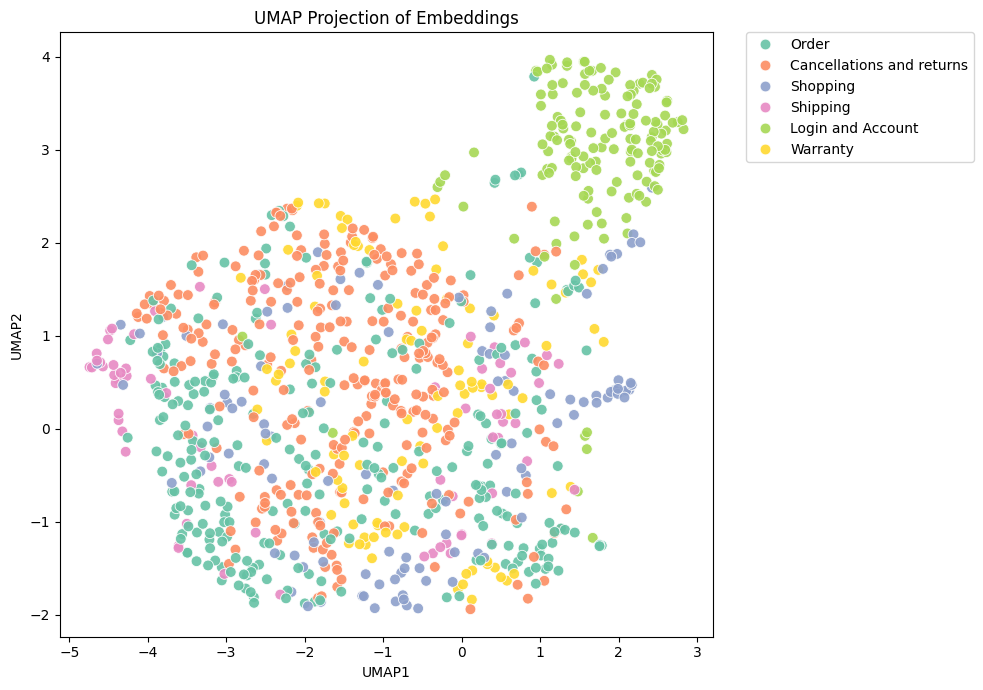

In [9]:


plot_umap_embeddings(data_df)

In [10]:
data_df_X= data_df.drop(columns=["label", "issue_area", "embedding", "text", "conversation"])
data_df_Y = data_df["issue_area"]

In [11]:
train_x, test_x , train_y, test_y = train_test_split(data_df_X,data_df_Y, test_size=0.2, stratify=data_df_Y, random_state=22 )

In [12]:
model = LogisticRegression(
    multi_class='ovr',
    solver='liblinear',
    class_weight='balanced',
    max_iter=200
)
model.fit(train_x, train_y)

/Users/ritkumar17/Desktop/R&D_Project/LLM_fine/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(class_weight='balanced', max_iter=200, multi_class='ovr',
                   solver='liblinear')

In [13]:
y_train_pred = model.predict(train_x)
y_test_pred= model.predict(test_x)

train_f1 = f1_score(train_y, y_train_pred, average='weighted')
test_f1 = f1_score(test_y, y_test_pred, average='weighted')


print(f"Train F1-score: {train_f1:.2f}")



print("\n Final Test Set Performance:")
print(f"Test F1-score:  {test_f1:.2f}")
print(classification_report(test_y, y_test_pred))

Train F1-score: 0.92

 Final Test Set Performance:
Test F1-score:  0.83
                           precision    recall  f1-score   support

Cancellations and returns       0.86      0.95      0.90        57
        Login and Account       0.94      1.00      0.97        30
                    Order       0.79      0.70      0.75        54
                 Shipping       0.64      0.47      0.54        15
                 Shopping       0.83      0.83      0.83        23
                 Warranty       0.87      0.95      0.91        21

                 accuracy                           0.84       200
                macro avg       0.82      0.82      0.81       200
             weighted avg       0.83      0.84      0.83       200



# With Fine tune model

In [14]:
model_name = "/Users/ritkumar17/Desktop/R&D_Project/LLM_fine/llm_fine/LLM_fine_Tune"
tokenizer_name= "bert-base-uncased"

In [15]:
embeddings_df = embedded_generation(model_name,tokenizer_name, df["conversation"].to_list())

In [16]:
data_df = embeddings_df.merge(df, how="inner", left_on = "text", right_on = "conversation")
data_df["embedding"] = data_df.iloc[:, 0:768].apply(lambda row: np.array(row), axis=1)

/Users/ritkumar17/Desktop/R&D_Project/LLM_fine/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/ritkumar17/Desktop/R&D_Project/LLM_fine/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


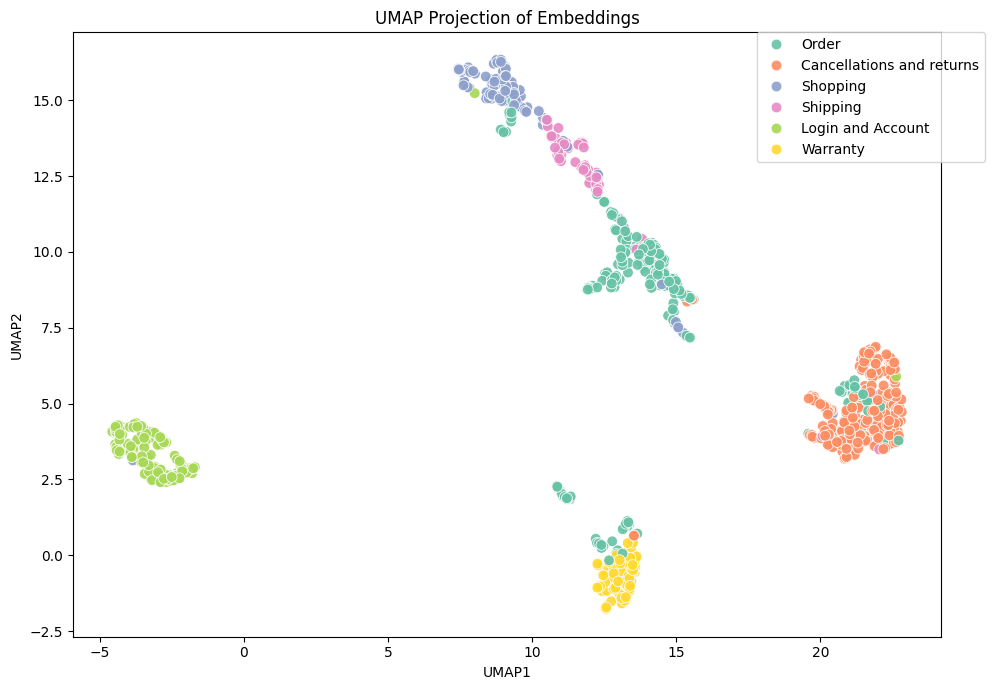

In [17]:
plot_umap_embeddings(data_df)

In [18]:
data_df_X= data_df.drop(columns=["label", "issue_area", "embedding", "text", "conversation"])

In [19]:
data_df_Y = data_df["issue_area"]

In [20]:
data_df_X

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.502320,0.231399,-0.169805,-0.175404,-0.133942,0.101385,-0.195809,0.174067,-0.064698,-0.007519,...,0.195638,-0.188858,0.350104,-0.647879,-0.600531,-0.102350,-0.110358,0.985459,-0.264428,-0.093637
1,-0.433765,0.347670,-0.366653,0.154855,-0.102037,0.231412,-0.528088,0.116795,0.024136,-0.167438,...,0.103556,-0.245666,0.283794,-0.528225,-0.404396,-0.474305,-0.040183,1.113485,-0.050853,-0.122488
2,-0.177099,-0.321951,0.470486,0.150602,0.120010,-0.413119,0.164415,0.123513,-0.038540,-0.088554,...,-0.272721,0.009328,-0.144975,-0.202420,-0.458320,0.399751,-0.023939,0.246078,-0.210881,-0.262635
3,-0.440467,0.281957,-0.163607,-0.271410,-0.162766,0.207853,-0.339693,0.216354,-0.115114,-0.189971,...,0.238158,-0.146422,-0.046535,-0.673787,-0.526521,0.013372,-0.238941,1.064443,-0.230057,-0.058106
4,-0.555101,0.215974,-0.327143,-0.080151,-0.186323,0.259810,-0.223530,0.159151,0.029525,-0.171367,...,0.206999,-0.306817,0.347256,-0.550389,-0.683447,-0.170794,-0.071308,1.144691,-0.134259,-0.122073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.353418,-0.452407,-0.144754,-0.387011,0.207249,0.243453,-0.560856,0.228292,-0.038801,-0.372535,...,-0.116759,-0.508639,-0.219958,-0.399922,-0.790053,0.206996,-0.085813,0.575752,-0.184103,-0.410651
996,-0.375247,0.214907,-0.051142,-0.177247,-0.056474,0.149429,-0.356948,0.104825,-0.039664,-0.108881,...,0.105892,-0.438026,0.319271,-0.837408,-0.608101,-0.048961,-0.233123,1.134640,-0.345799,0.035025
997,-0.189454,-0.317208,0.305979,-0.364683,-0.506991,-0.343609,0.038214,-0.056523,-0.204552,0.491478,...,0.400284,0.055442,-0.828074,-0.833988,-0.012511,0.353379,-0.416646,0.261845,-0.647224,-0.037564
998,-0.189454,-0.317208,0.305979,-0.364683,-0.506991,-0.343609,0.038214,-0.056523,-0.204552,0.491478,...,0.400284,0.055442,-0.828074,-0.833988,-0.012511,0.353379,-0.416646,0.261845,-0.647224,-0.037564


In [21]:
train_x, test_x , train_y, test_y = train_test_split(data_df_X,data_df_Y, test_size=0.2, stratify=data_df_Y, random_state=22 )

In [22]:
model = LogisticRegression(
    multi_class='ovr',
    solver='liblinear',
    class_weight='balanced',
    max_iter=200
)
model.fit(train_x, train_y)



/Users/ritkumar17/Desktop/R&D_Project/LLM_fine/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(class_weight='balanced', max_iter=200, multi_class='ovr',
                   solver='liblinear')

In [23]:

y_train_pred = model.predict(train_x)
y_test_pred= model.predict(test_x)

train_f1 = f1_score(train_y, y_train_pred, average='weighted')
test_f1 = f1_score(test_y, y_test_pred, average='weighted')


print(f"Train F1-score: {train_f1:.2f}")



print("\n Final Test Set Performance:")
print(f"Test F1-score:  {test_f1:.2f}")
print(classification_report(test_y, y_test_pred))

Train F1-score: 0.99

 Final Test Set Performance:
Test F1-score:  0.95
                           precision    recall  f1-score   support

Cancellations and returns       0.93      0.98      0.96        57
        Login and Account       1.00      1.00      1.00        30
                    Order       0.92      0.91      0.92        54
                 Shipping       0.94      1.00      0.97        15
                 Shopping       1.00      0.83      0.90        23
                 Warranty       0.95      1.00      0.98        21

                 accuracy                           0.95       200
                macro avg       0.96      0.95      0.95       200
             weighted avg       0.95      0.95      0.95       200

